
### Project Description:

This dataset consists of reviews of fine foods from amazon downloaded from Kaggle. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.   

[Data Link](https://www.kaggle.com/snap/amazon-fine-food-reviews)

The dataset includes text review and a short summary for the same and we will use this information to build Text Summarization model using RNN with LSTM layers along with Global Attention Mechanism


In [1]:
# importing necessary libraries

import numpy as np  
import pandas as pd 
import pickle
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# used attention layer implementation from: https://github.com/thushv89/attention_keras/blob/master/layers/attention.py
from attention import AttentionLayer


Using TensorFlow backend.


Loading data annd removing duplicates and empty rows:

In [2]:
dat_dir = '/Users/ritayu/Downloads/amazon-fine-food-reviews/'

# loading dataset - around 0.5 million records
reviews_data = pd.read_csv(dat_dir+ 'Reviews.csv')

# dropping all duplicates of 'Text' in reviews_data
reviews_data.drop_duplicates(subset=['Text'],inplace=True)
# dropping all rows with na
reviews_data.dropna(axis=0,inplace=True)

Looking at 5 top rows of data to have an idea about the text and its summary:

In [3]:
for txt in reviews_data['Text'].head():
    print(txt)
    print('\n')

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".


This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.


If you are looking for the se

In [4]:
reviews_data['Summary'].head()

0    Good Quality Dog Food
1        Not as Advertised
2    "Delight" says it all
3           Cough Medicine
4              Great taffy
Name: Summary, dtype: object

Preprocessing and Cleaning the data:

In [5]:
# found abbrevations dictionary online and using it to clean text
# saved the python dictionary available online in pickle format and loading it
file_open = open(dat_dir+'abv_mapping.pkl','rb')
abv_mapping = pickle.load(file_open)
file_open.close()

# creating a text cleaning function
# importing english stopwords from NLTK corpus
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    # lower the string
    updated_string = text.lower()
    # using BeautifulSoup ti identify html tags and removing the tags
    updated_string = BeautifulSoup(updated_string, "lxml").text
    # removing text inside parenthesis
    updated_string = re.sub(r'\([^)]*\)', '', updated_string)
    # removing quotes from text
    updated_string = re.sub('"','', updated_string)
    # treating abbrevations with the mapping
    updated_string = ' '.join([abv_mapping[t] if t in abv_mapping else t for t in updated_string.split(" ")])   
    # removing apostrophe s
    updated_string = re.sub(r"'s\b","",updated_string)
    # removing numbers and other punctuations and special characters
    updated_string = re.sub("[^a-zA-Z]", " ", updated_string) 
    # removing stop words from text
    tokens = [w for w in updated_string.split() if not w in stop_words]
    # 1 or 2 letter words usually dont carry any meaning and removing them from text
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

# generating cleaned text
cleaned_text = []
for text in reviews_data['Text']:
    cleaned_text.append(text_cleaner(text))

# reviews_data preprocessing - 'Summary' Cleaning
# creating similar cleaning function as text cleaner
    
def summary_cleaner(text):
    # lower casing the string
    updated_string = text.lower()
    # removing quotes
    updated_string = re.sub('"','', text)
    # mapping abbrevations
    updated_string = ' '.join([abv_mapping[t] if t in abv_mapping else t for t in updated_string.split(" ")])  
    # removing 's from reviews_data
    updated_string = re.sub(r"'s\b","",updated_string)
    # removing numbers, special characters and other punctuations from reviews_data
    updated_string = re.sub("[^a-zA-Z]", " ", updated_string)
    # considering all words that are more than single alphabet for summary
    tokens=updated_string.split()
    updated_string=''
    for i in tokens:
        if len(i)>1:                                 
            updated_string=updated_string+i+' '  
    return updated_string

# generating cleaned summary
cleaned_summary = []
for summary in reviews_data['Summary']:
    cleaned_summary.append(summary_cleaner(summary))

In [6]:
# updating reviews_data
reviews_data['cleaned_text']=cleaned_text
reviews_data['cleaned_summary']=cleaned_summary
reviews_data['cleaned_summary'].replace('', np.nan, inplace=True)
# removing entries where
reviews_data.dropna(axis=0,inplace=True)

Adding a START and END token to the summary to help model understand the starting word and the end of summary

In [7]:
# we will add <start> and <end> tokens to the summary for RNN to understand starting and end of summary while training
reviews_data['cleaned_summary'] = reviews_data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

# taking look at cleaned text and summary
for i in range(5):
    print("Review: ",reviews_data['cleaned_text'][i])
    print("Summary: ",reviews_data['cleaned_summary'][i])
    print("\n")

Review:  bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary:  _START_ Good Quality Dog Food  _END_


Review:  product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary:  _START_ Not as Advertised  _END_


Review:  confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary:  _START_ Delight says it all  _END_


Review:  looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary:  _START_ Cough Medicine  _END_


Review:  great taffy great price wide assortment yummy taffy delivery quick

Analyzing the length of text and the summary for various records in the data:

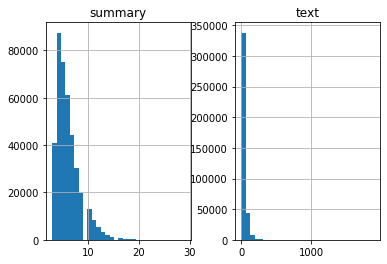

In [8]:
# plotting the length of text and summary to understand the ideal lengths for the RNN model
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in reviews_data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in reviews_data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

Majority of the summary seems to be 10 words long and majority of text seems to be 80-90 words long. We will use this information while building fixed length encoder-decorder network structure.

In [9]:
# saving the processed data file for uploading to google colab for training
reviews_data.to_csv(dat_dir+'reviews.csv', index = False)

In [10]:
max_len_text=80 
max_len_summary=10

# using sklearn to split reviews_data into training and testing
x_train,x_val,y_train,y_val=train_test_split(reviews_data['cleaned_text'],reviews_data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True) 

Keras library incorporates modules for processing textual data. We will use these to prepare the fixed length data for the model.

In [11]:
# preparing a tokenizer for 'Text'
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

#convert text sequences into integer sequences
x_train    =   x_tokenizer.texts_to_sequences(x_train) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length if length of text is small
# padding with default trimming to 'pre' to make sure that the 'end' token is always in the reviews_data
x_train    =   pad_sequences(x_train,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

# size of vocabolary + 1 to be feed into embedding layer
x_vocab_size   =  len(x_tokenizer.word_index) +1 


#preparing a tokenizer for 'Summary' on training reviews_data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

#convert summary sequences into integer sequences
y_train    =   y_tokenizer.texts_to_sequences(y_train) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length if length of summary is less than maximum length
y_train    =   pad_sequences(y_train, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

# size of vocabolary + 1 to be feed into embedding layer
y_vocab_size  =   len(y_tokenizer.word_index) +1

Building the Encoder-Decoder Neural Network architecture using LSTM layers along with Attention Layer to help the model learn which parts of text to give importance while predicting the next word of the summary. We will use 3 stacked LSTM layers for the Encoder and single layer LSTM along with Attention Layer followed by Dense layer in the Decoder.  

Time Distributed Dense layer is used so that we can use apply the same dense layer for every time steps of a data point.

In [12]:
# using 300 dimension for the embedding layer and lstm layer, different models with different latent dimensions can be tried to fine tune the model
embed_dim = 300
lstm_dim = 300

K.clear_session() 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
# if more time permits, we can use glove or word2vec pre-trained embeddings as well and compare model efficiency
encoder_embed = Embedding(x_vocab_size, embed_dim,trainable=True)(encoder_inputs) 

# implementing Unidirection LSTM, we can try Bidirectional LSTM for improving model accuracy if time permits
#LSTM Layer 1 
encoder_lstm1 = LSTM(lstm_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embed) 

#LSTM Layer 2 
encoder_lstm2 = LSTM(lstm_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM Layer 3 
encoder_lstm3 = LSTM(lstm_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. Defining input to take any shape
decoder_inputs = Input(shape=(None,)) 
# embedding the output variable
decoder_embed_layer = Embedding(y_vocab_size, embed_dim,trainable=True) 
decoder_embed = decoder_embed_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(lstm_dim, return_sequences=True, return_state=True) 
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(decoder_embed,initial_state=[state_h, state_c]) 

#Attention Layer - implementation referenced from internet
# Referenced Papers - https://arxiv.org/abs/1508.04025.pdf, https://arxiv.org/pdf/1409.0473.pdf
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_vocab_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 300)      34403400    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 300), (N 721200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

Compiling the model and fitting the model. The model was trained on google colab and weights from saved model will be loaded into the notebook.     

Callbacks:   
Defining callbacks for the model, Early Stopping as regularizer to prevent overfitting of the model.   
ReduceLROnPlateau for reducing learning rate when model hits bottleneck and the chosen metric stops improving.  
ModelCheckpoint to save the weights corresponding to the best model fit.

In [17]:
# compiling model and using rmsprop optimizer and sparse categorical cross-entropy as it converts integer sequence to a one-hot vector
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# adding regularization in terms of early stopping and storing weights for best model
callbcks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10),
            ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
            ModelCheckpoint(dat_dir+'model-rnn-summary.h5', monitor = 'loss', verbose=1, save_best_only=True, save_weights_only=True)]

# fitting model on reviews_data
results = model.fit([x_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,epochs=10,callbacks=callbcks, batch_size=32, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Loading the weights of the model trained on Google Colab.

In [18]:
# loading weights and the model fit results:

model.load_weights(dat_dir+'model-rnn-summary-gpu.h5')

# model results
results = np.load(dat_dir+'rnn-model_results.npy', allow_pickle='TRUE').item()

Visualizing the model fit results:

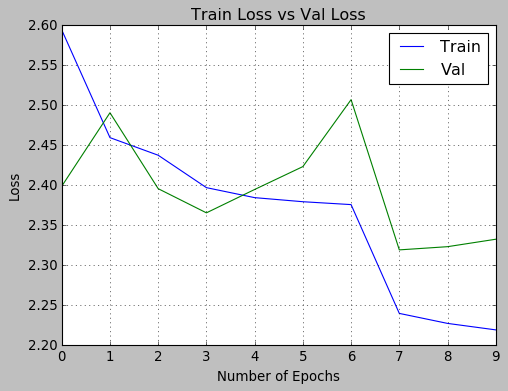

In [19]:
# vizualizing the model fit results
import matplotlib.pyplot as plt

# extracting loss and accuracy from results
train_loss=results['loss']
val_loss=results['val_loss']
# setting x axis as per number of epochs
xc=range(len(results['loss']))

plt.figure(figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs Val Loss')
plt.grid(True)
plt.legend(['Train','Val'])
plt.style.use(['classic'])

plt.show()

Building the inference model which will be used to predict the summary for new text:

In [22]:
# building dictionaries to generate words back from numerical reference
reverse_target_word_index = y_tokenizer.index_word 
reverse_source_word_index = x_tokenizer.index_word 
target_word_index = y_tokenizer.word_index

# we need encoder and decoder model for  prediction, therefore building the encoder and decoder model separately
# encoder inference for prediction
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference for prediction
# Below objects will hold the states of the previous time step
decoder_state_input_h = Input(shape=(lstm_dim,))
decoder_state_input_c = Input(shape=(lstm_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,lstm_dim))

# Get the embeddings of the decoder sequence
decoder_embed2= decoder_embed_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(decoder_embed2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob distribution over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

Defining a function that uses the above encoder and decoder model to generate summary:

In [23]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    encode_out, encode_h, encode_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, decode_h, decode_c = decoder_model.predict([target_seq] + [encode_out, encode_h, encode_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        encode_h, encode_c = decode_h, decode_c

    return decoded_sentence

The following functions help convert sequence of numbers to text:

In [24]:
# defining function for convert integer sequence to summary
def seq2summary(input_seq):
    updated_string=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        updated_string=updated_string+reverse_target_word_index[i]+' '
    return updated_string

# defining function for convert integer sequence to text
def seq2text(input_seq):
    updated_string=''
    for i in input_seq:
      if(i!=0):
        updated_string=updated_string+reverse_source_word_index[i]+' '
    return updated_string

Trained Model in Action:   

Generating summary predictions and comparing with actual summary available for 15 data rows of validation data

In [28]:
for i in range(15):
  print("Review:\t",seq2text(x_val[i]))
  print("Original summary:\t",seq2summary(y_val[i]))
  print("Predicted summary:\t",decode_sequence(x_val[i].reshape(1,max_len_text)))
  print("\n\n")

Review:	 love hot sauces rediculous thought like good hot sauce would good tacos nachos etc nice heat stuff stupid hot bought three pack regreted moment tried standard insanity sauce cannot even tolerate dashes tacos good 
Original summary:	 seriously 
Predicted summary:	  hot hot hot



Review:	 whenever want add bit cream soup sauce never seem around use cream often enough even buy smallest container stuff kept long time really add creamy flavor glad found 
Original summary:	 this stuff is great 
Predicted summary:	  great sauce



Review:	 glad opportunity purchase last boxes amazing tea local herb stores tell sold anymore cannot sold unless ground powder form hope buy overseas batch runs 
Original summary:	 last of the best 
Predicted summary:	  great tea



Review:	 tried peanut butter creme version first impression fudge coating looker rather soft would messy left warm day tasting overwhelming sweetness predominant aside sweetness flavor butterfinger reeses slight crunchiness coo

### Conclusion:

The neural network performs decently on the validation dataset after training for 10 epochs on Google Colab. The model can be trained for more epochs to furthur increase the accuracy as we continued to improve accuracy after each epoch. Considering the complex nature of the problem to generate an abstractive summary i.e. it formulates new words as summary rather than just selecting parts of the text (which is the case of textRank algorithm similar to PageRank algorithm), it can be considered that model does fairly good with limited training and dataset volume. The attention mechanism also helped in generating better summary as it adds context to the decoder part of the model to generate meaningful predictions.

On reading the results from the above predictions, the predicted summary mostly makes sense. We do observe that in very few observations, the true summary of the text blocks needs to be updated to better represent the data and that will help in further improve the model results.